In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
concrete_compressive_strength = fetch_ucirepo(id=165) 
  
# data (as pandas dataframes) 
X = concrete_compressive_strength.data.features 
y = concrete_compressive_strength.data.targets 
  
# metadata 
print(concrete_compressive_strength.metadata) 
  
# variable information 
print(concrete_compressive_strength.variables) 


{'uci_id': 165, 'name': 'Concrete Compressive Strength', 'repository_url': 'https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength', 'data_url': 'https://archive.ics.uci.edu/static/public/165/data.csv', 'abstract': 'Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. ', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1030, 'num_features': 8, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Concrete compressive strength'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sun Feb 11 2024', 'dataset_doi': '10.24432/C5PK67', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'title': 'Modeling of strength of high-performance concrete using artificial neural networks', 'authors': 'I. Yeh', 'published_in': 'Cement and Concrete Res

In [2]:
# normalize data 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# y_scaler = StandardScaler()
# y_normalized = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.3, random_state=42)

In [3]:
import torch 

if torch.backends.mps.is_available():
    device = "mps"
    
elif torch.cuda.is_available():
    device = "cuda"

else:
    device = "cpu"    

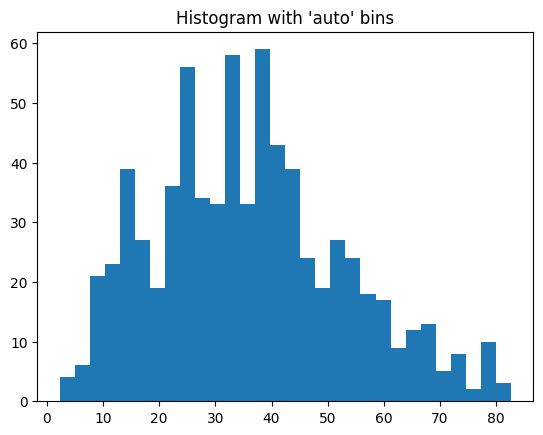

In [105]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import os
import matplotlib.pyplot as plt

#os.environ['KMP_DUPLICATE_LIB_OK']='True'

# data = pd.read_csv('/content/02_Linear_Regression_Model_Data.csv')
y_train = y_train.flatten()
y_test = y_test.flatten()
hist, bin_edges, _ = plt.hist(y_train, bins='auto')  # arguments are passed to np.histogram
# hist, bin_edges, _ = plt.hist(y_train, bins=30)  # arguments are passed to np.histogram
class_digits = np.digitize(y_train, bin_edges) # Get the class of each point using histogram bins

no_of_classes = bin_edges.shape[0]+1
one_hots = np.zeros((y_train.size, no_of_classes))
one_hots[np.arange(y_train.size), class_digits] = 1

test_hots = np.zeros((y_test.size, no_of_classes))
test_hots[np.arange(y_test.size), np.digitize(y_test, bin_edges)] = 1

plt.title("Histogram with 'auto' bins")
plt.show()

# Avoid copy data, just refer
train_x_tr = torch.from_numpy(X_train.reshape([-1,8])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
train_y_scalar = torch.from_numpy(y_train.reshape([-1,1])).float()#torch.from_numpy(data['y'].values[:1000]).unsqueeze(dim=1).float()
train_y_tr = torch.from_numpy(one_hots.reshape([-1, no_of_classes])).float()#torch.from_numpy(data['y'].values[:1000]).unsqueeze(dim=1).float()

test_x_tr = torch.from_numpy(X_test.reshape([-1,8])).float()#torch.from_numpy(data['x'].values[1000:]).unsqueeze(dim=1).float()
test_y_scalar = torch.from_numpy(y_test.reshape([-1,1])).float()#torch.from_numpy(data['y'].values[1000:]).unsqueeze(dim=1).float()
test_y_tr = torch.from_numpy(test_hots.reshape([-1, no_of_classes])).float()#torch.from_numpy(data['y'].values[1000:]).unsqueeze(dim=1).float()


In [65]:
class QClassifier(torch.nn.Module):
    def __init__(self, in_size=1, no_of_classes=55):
        super(QClassifier,self).__init__()
        self.in_size = in_size
        self.out_size = no_of_classes

        hidden_layer = 64

        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.in_size, hidden_layer),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(hidden_layer, hidden_layer),
            # torch.nn.Dropout(p=0.9),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(hidden_layer, self.out_size)
            )

    def forward(self,x):
        return self.net(x)



In [94]:
train_x_tr = train_x_tr.to(device)
train_y_tr = train_y_tr.to(device)

model = QClassifier(in_size=8, no_of_classes=no_of_classes).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.001,weight_decay=0.0001)

In [95]:
train_x_tr.shape

torch.Size([721, 8])

In [96]:

losses = []
for step in range(2000):
    model.train()
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    logits = model(train_x_tr)
    loss = criterion(logits, train_y_tr)
    losses.append(loss.data.item())
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step==0) or ((step+1) % 1000 == 0):
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass

epoch 1 loss=3.466
epoch 1000 loss=1.018
epoch 2000 loss=0.4804


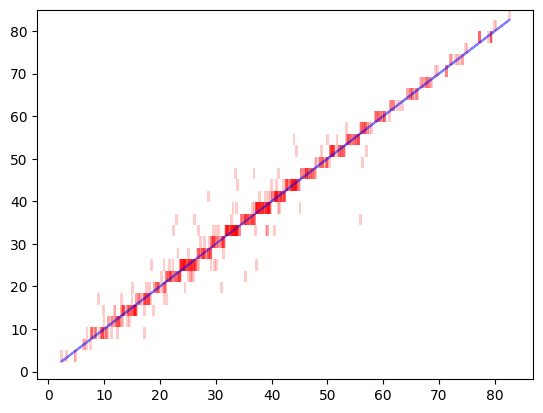

In [97]:
import matplotlib.pyplot as plt 
import numpy as np


min_val, max_val = 0,85
intervals = np.array(list(zip([min_val, *bin_edges], [*bin_edges, max_val])))

# plt.scatter(y_train,train_pred[:,1])

model.eval()

y_pred = model(train_x_tr.to(device))
probs = y_pred.softmax(dim=1)

sorted_pdf, sorted_indices = probs.detach().cpu().sort(dim=1, descending=True)
sorted_cdf = sorted_pdf.cumsum(dim=1)
tau = 0.001
first_nth_indices = ((sorted_cdf >= tau)*1).argmax(dim=1)


plt.plot(y_train,y_train, color='blue',alpha=0.5)

for i in range(sorted_indices.shape[0]):
        # print(sorted_indices[i][:first_nth_indices[i]+1])
        prediction_set = sorted_indices[i, :first_nth_indices[i]+1]
        for j in range(len(prediction_set)):
                bar_max, bar_min = intervals[prediction_set[j]]
                plt.bar(y_train[i], height= bar_max-bar_min, bottom=bar_min, width= 0.5 ,color='red', alpha=0.2)

In [98]:
true_count = 0

gt = train_y_tr.argmax(dim=1).cpu()

for i in range(sorted_indices.shape[0]):
        # print(sorted_indices[i][:first_nth_indices[i]+1])
        prediction_set = sorted_indices[i, :first_nth_indices[i]+1]
        if gt[i] in prediction_set:
                true_count += 1

picp = true_count / sorted_indices.shape[0]
ace = picp - tau
print(f'PICP: {picp}, ACE: {ace}')

PICP: 0.869625520110957, ACE: 0.868625520110957


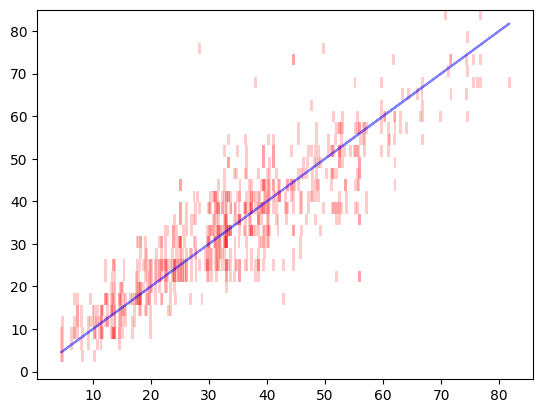

In [103]:
import matplotlib.pyplot as plt 
import numpy as np


model.eval()
y_pred = model(test_x_tr.to(device))
probs = y_pred.softmax(dim=1)

sorted_pdf, sorted_indices = probs.detach().cpu().sort(dim=1, descending=True)
sorted_cdf = sorted_pdf.cumsum(dim=1)
tau = 0.90
first_nth_indices = ((sorted_cdf >= tau)*1).argmax(dim=1)


plt.plot(y_test,y_test, color='blue',alpha=0.5)

for i in range(sorted_indices.shape[0]):
        # print(sorted_indices[i][:first_nth_indices[i]+1])
        prediction_set = sorted_indices[i, :first_nth_indices[i]+1]
        for j in range(len(prediction_set)):
                bar_max, bar_min = intervals[prediction_set[j]]
                plt.bar(y_test[i], height= bar_max-bar_min, bottom=bar_min, width= 0.5 ,color='red', alpha=0.2)

In [104]:
true_count = 0

gt = test_y_tr.argmax(dim=1)

for i in range(sorted_indices.shape[0]):
        # print(sorted_indices[i][:first_nth_indices[i]+1])
        prediction_set = sorted_indices[i, :first_nth_indices[i]+1]
        if gt[i] in prediction_set:
                true_count += 1

picp = true_count / sorted_indices.shape[0]
ace = picp - tau
print(f'PICP: {picp}, ACE: {ace}')

PICP: 0.5210355987055016, ACE: -0.3789644012944984


In [73]:
sorted_indices

tensor([[16, 14, 19,  ...,  4,  2,  3],
        [13,  8, 17,  ...,  2,  4,  1],
        [26, 22, 29,  ...,  2,  4,  1],
        ...,
        [10, 14, 11,  ...,  3,  5,  1],
        [13, 16, 12,  ..., 31, 29,  1],
        [20, 23, 18,  ...,  4,  2,  1]])

In [74]:
first_nth_indices

tensor([ 5, 10,  7,  7,  2,  6,  5,  6,  7,  5,  5,  4,  7,  4,  4,  4,  4,  6,
         4,  7,  7,  4,  3,  3,  8,  5,  2,  6,  4,  5,  5,  5,  2,  2,  6,  4,
         6,  7,  4,  6,  4,  3,  4,  6,  4,  4,  8,  3,  3,  4,  5,  6,  4,  5,
         2,  8,  4,  3,  4,  4,  6,  4,  6, 10,  6,  5,  3,  4,  6,  6,  3,  5,
         2,  5,  5,  4,  5,  5,  3,  3,  5,  6,  5,  3,  2,  7,  5,  5,  5,  4,
         5,  3,  4,  3,  5,  5,  5,  8,  6,  5,  7,  7,  4,  7,  3,  2,  3,  4,
         5,  2,  4,  3,  6,  3,  6,  4,  5,  2,  6,  5,  3,  5,  7,  5,  5,  5,
         6,  9,  6,  4,  3,  6,  4,  3,  3,  3,  4,  5,  6,  1,  2,  3,  2,  5,
         8,  5,  7,  4,  3,  4,  4,  0,  5,  3,  6,  4,  4,  3, 10,  7,  5,  5,
         7,  1, 10,  6,  3,  6,  8,  5,  6,  6,  4,  2,  4,  4,  5,  4,  7,  5,
         4,  5,  2,  5,  7,  4,  5,  6,  4,  4,  3,  7,  6,  4,  3,  7,  8,  0,
         7,  5, 11,  4,  3,  9,  2,  5,  5,  7,  6,  3,  3,  6,  6,  6,  6,  2,
         2,  3,  4,  8,  3,  6,  7,  4, 